<a href="https://colab.research.google.com/github/JosetteMATANG/JosetteMATANG/blob/main/ML1_TP_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='darkblue'> **TP de Machine Learning 1**

-  Nom de l'étudiant : <font color='green'> Josette Victoire MATANG KUETE </font>

- Classe :  **ISE2**

- Etablissement: **Ecole nationale de la Statistique et de l'Analyse économique**

In [ ]:
!()


# <font color='darkblue'> **Avant-propos** </font>


Dans ce notebook, nous allons traiter les exercices 1 et 2 sans toutefois revenir sur certaines parties du notebook *regression.ipynb* comme l'exploration de la base de données, la régressio linéaire, etc.

# <font color='darkblue'>  **Packages** </font>

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=77d3ddf2352712e0c5c01ecb184c4e5653e8eb02c26cc62abb5601989da30f38
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


# <font color='darkblue'> **Importation de la base de données billets.csv** </font>

In [ ]:
data_link = "https://raw.githubusercontent.com/MouslyDiaw/tp-supervised-learning/refs/heads/master/billets.csv"
data = pd.read_csv(data_link, sep=";")
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# <font color='darkblue'> **Modélisation** </font>

### <font color='darkblue'>Préliminaires

In [ ]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [ ]:
# Extraction des valeurs non nulles de la variable cible dans une nouvelle base
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

# Création des variables explicatives et cible
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]
y = data_model.loc[:, 'margin_low']

# Séparons nos données en un jeu d'entraînement et un jeu de test : 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#random_test permet de générer le même jeu de données pour le test et le train
print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


### <font color='darkblue'> Standardisation

In [ ]:
# Standardisons les données :
std_scaler = StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

### <font color='darkblue'> Définition d'une fonction d'entrainement

In [70]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)

    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Test error: {round(error_test, 5)}")
    print(f"Train error: {round(error_train, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

### <font color='darkblue'> Elastic net

In [66]:
# Train and evaluate elasticnet regression
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Test error: 0.42698
Train error: 0.44608


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


# <font color='darkblue'> **Exercice 1** </font>

Dans la cellule précédente, veuillez analyser les variables explicatives: que constatez vous entre le jeu de train et le jeu de test?


In [ ]:
#Transformation de X_train_std en dataframe
X_train_std_df = pd.DataFrame(X_train_std, columns=["diagonal","height_left","height_right","margin_up","length"])
X_train_std_df.head()

,diagonal,height_left,height_right,margin_up,length
0,-1.070742,0.546293,0.548062,1.918434,0.050886
1,-0.406474,0.946010,1.773089,-0.681685,-1.851434
2,-1.203595,-0.053283,-0.064451,-0.031655,0.543656
3,-0.173981,0.446364,-0.921970,-1.158373,0.062346
4,0.291006,0.546293,0.578688,0.921722,-1.713917


In [ ]:
X_train_std_df.describe(include="all")

,diagonal,height_left,height_right,margin_up,length
count,1.024000e+03,1.024000e+03,1.024000e+03,1.024000e+03,1.024000e+03
mean,-1.272212e-13,-1.526557e-15,1.703152e-14,3.564857e-16,2.862294e-15
std,1.000489e+00,1.000489e+00,1.000489e+00,1.000489e+00,1.000489e+00
min,-3.030330e+00,-2.718062e+00,-3.096393e+00,-2.588439e+00,-3.100547e+00
25%,-7.053947e-01,-6.944951e-01,-6.769649e-01,-7.250201e-01,-7.226474e-01
50%,-7.914122e-03,1.333691e-02,-3.200143e-03,-7.499041e-02,3.144607e-01
75%,7.227799e-01,6.795318e-01,7.318160e-01,6.617099e-01,7.527964e-01
max,3.080929e+00,2.811355e+00,3.151244e+00,3.261829e+00,1.884448e+00


Les données du jeu d'entraînement sont des données standardisées. Elles se situent entre -3 et 3 environ.
Les données d'entrainement ne le sont pas.

Les graphiques ci-après donnent une visualisation des distributions.

### <font color='darkblue'> **Distribution des variables : tracés des histogrammes**

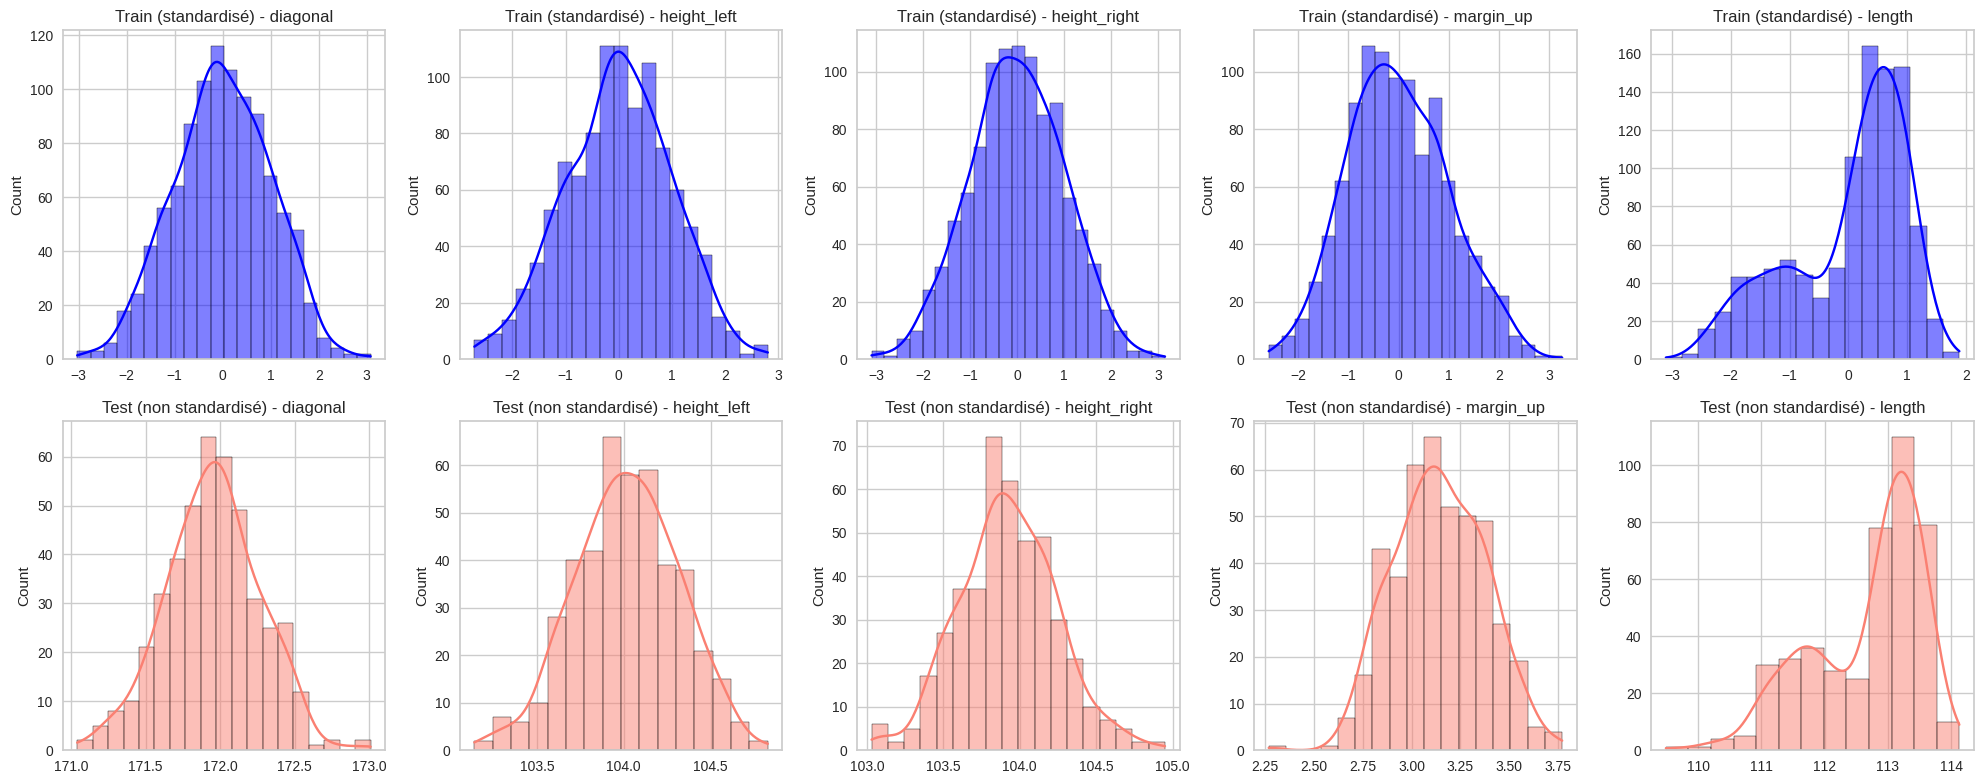

In [ ]:
# Création d'une figure avec deux lignes : une pour le train, une pour le test
variables = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
fig, axes = plt.subplots(2, len(variables), figsize=(20, 8), sharey=False)

# Histogrammes pour les données standardisées (X_train_std_df)
for i, var in enumerate(variables):
    sns.histplot(X_train_std_df[var], kde=True, ax=axes[0, i], color='blue')
    axes[0, i].set_title(f"Train (standardisé) - {var}")
    axes[0, i].set_xlabel("")

# Histogrammes pour les données non standardisées (X_test)
for i, var in enumerate(variables):
    sns.histplot(X_test[var], kde=True, ax=axes[1, i], color='salmon')
    axes[1, i].set_title(f"Test (non standardisé) - {var}")
    axes[1, i].set_xlabel("")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

Ces histogrammes montrent que les jeux de données X_train et X_test ont des distributions similaires. Cependant, elles ne sont pas à la même échelle comme vu précédemment.

### <font color='darkblue'> **Erreurs**

In [68]:
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Test error: 0.42698
Train error: 0.44608


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


  - *Train Error* représente l'erreur quadratique moyenne (MSE) sur le jeu de données d'entraînement. Ici, l'erreur est de 0.44608.

  - *Test Error* quant à lui le MSE sur le jeu de test. L'erreur de test donne une idée de la capacité du modèle à généraliser, c'est-à-dire à effectuer des prédictions sur des données qu'il n'a pas vues pendant l'entraînement. Ici, l'erreur est légèrement plus faible 0.42698 que celle sur l'entraînement.

Cela peut signifier que **le modèle ne surajuste pas** (pas de overfitting) : Lorsque l'erreur de test est similaire ou légèrement inférieure à l'erreur d'entraînement, cela peut signifier que le modèle ne surajuste pas. Dans ce cas, le modèle semble avoir trouvé un bon compromis entre l'ajustement aux données d'entraînement et la généralisation aux nouvelles données.


### <font color='darkblue'> **Prédictions **

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


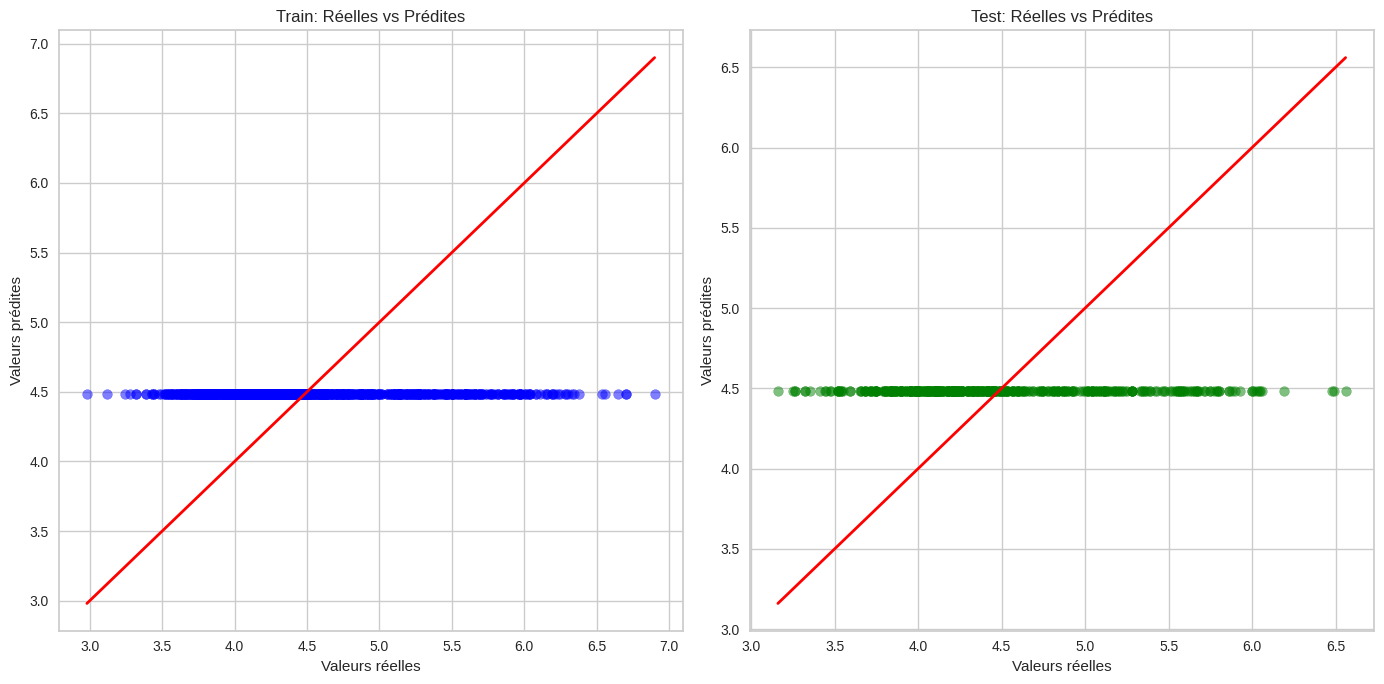

In [82]:
model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5)
# On entraîne ce modèle sur les données d'entrainement
model.fit(X_train_std, y_train)
# On récupère les prédictions sur le jeu de données train
y_train_pred = model.predict(X_train_std)
# Prédictions sur les données de test
y_test_pred = model.predict(X_test)

# Création des graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Graphique 1: Prédictions sur les données d'entraînement
ax1.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)  # ligne d'identité
ax1.set_title('Train: Réelles vs Prédites')
ax1.set_xlabel('Valeurs réelles')
ax1.set_ylabel('Valeurs prédites')

# Graphique 2: Prédictions sur les données de test
ax2.scatter(y_test, y_test_pred, color='green', alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # ligne d'identité
ax2.set_title('Test: Réelles vs Prédites')
ax2.set_xlabel('Valeurs réelles')
ax2.set_ylabel('Valeurs prédites')

# Affichage des graphiques
plt.tight_layout()
plt.show()

Dans les deux cas, nous constatons que les valeurs réelles s'éloignent des valaeurs prédites (car sinon, la courbe suivrait la droite d'équation $y=x$ , ce qui n'est pas le cas ici).

Le modèle n'est pas bon dans l'ensemble. On pourrait l'améliorer, par exemple en ajustant des hyperparamètres comme alpha ou l1_ratio pour ElasticNet, ou en testant d'autres modèles.


<font color='darkblue'> **Coefficients**

In [84]:
# Extraction des coefficients des variables explicatives
coef = model.coef_  # Remplacez par le modèle que vous avez ajusté
variables = X_train.columns  # Noms des variables explicatives

# Créer un DataFrame pour afficher les coefficients
# Récupérer les coefficients
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': model.coef_.round(5)
})
coef_df


,Variable,Coefficient
0,diagonal,-0.0
1,height_left,0.0
2,height_right,0.0
3,margin_up,0.0
4,length,-0.0


Tous les coefficients sont égaux à zéro, cela signifie que l'algorithme a appliqué une **régularisation trop forte**, forçant tous les coefficients vers zéro. Cela peut être dû au fait que le paramètre alpha est trop élevé, ce qui rend le modèle trop contraint. En effet, ElasticNet combine la régularisation L1 (Lasso) et L2 (Ridge), qui peuvent toutes deux pousser les coefficients vers zéro lorsque la régularisation est intense.

Il faudrait essayer de réduire la valeur de alpha pour permettre au modèle d'ajuster des coefficients non nuls.

# <font color='darkblue'>**Exercice 2 :**</font>
- Optimiser les modèles Ridge, Lasso et ElasticNet
- Etudier l'importance des variables dans chaque modèle

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet

<font color='darkblue'> **Définition d'une fonction pour l'optimisation des hyperparamètres** </font>

In [75]:
def optimize_model(model, X_train, y_train, X_test, y_test, param_grid):

    # Normalisation des données dans le pipeline
    pipe = Pipeline([("scaler", MinMaxScaler()), ("regressor", model)])
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Récupération des performances sur les jeux de données d'entraînement et de test
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    # Calcul du MSE pour l'entraînement et le test
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Récupération des meilleurs paramètres et du score
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
    print(f"Internal CV score: {grid_search.best_score_: .3f}")

    # Visualisation des scores par rapport aux valeurs d'hyperparamètres (ici alpha)
    param_name = list(param_grid.keys())[0]
    results = grid_search.cv_results_
    plt.plot(results["param_" + param_name], results["mean_test_score"], marker='o', label="Validation score")
    plt.xlabel(param_name)
    plt.ylabel("R2 Score")
    plt.title(f"R2 Score vs {param_name}")
    plt.legend()
    plt.show()

    print(f"Test R²: {test_score:.3f}")
    print(f"Train R²:{train_score:.3f}")
    print(f"MSE train: {mse_train:.3f}")
    print(f"MSE test: {mse_test:.3f}")
    return { "best_model": best_model, "train_score": train_score,
             "test_score": test_score, "cv_results": results,
             "mse_train": mse_train, "mse_test": mse_test,
    }


Notons que le $R^2$ pour mesure la proportion de la variance de *margin_low* expliquée par les variables explicatives. Plus ce score est élevé, plus le modèle est capable de bien expliquer la variabilité de margin_low.

### <font color='darkblue'> **Modèle Ridge**

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'regressor__alpha': 1}
Internal CV score:  0.460


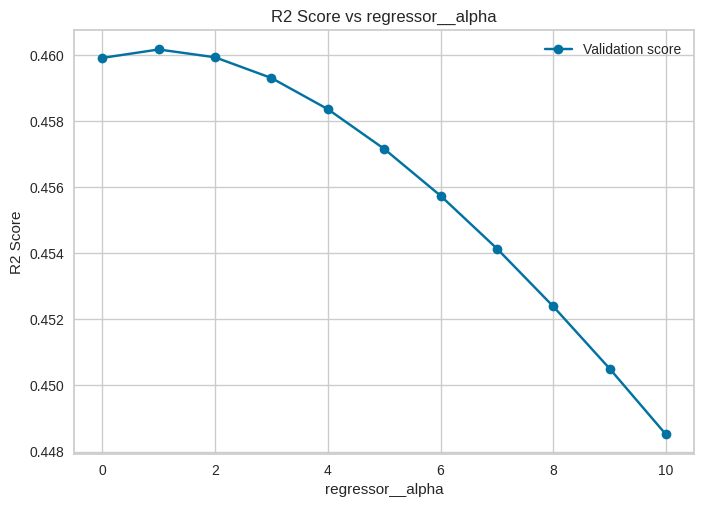

Test R²: 0.493
Train R²:0.470
MSE train: 0.236
MSE test: 0.216


In [76]:
param_grid_ridge = {
    "regressor__alpha": np.arange(0, 11, 1)  # valeurs de alpha allant de
}
ridge_results = optimize_model(Ridge(), X_train, y_train, X_test, y_test, param_grid_ridge)


A présent, nous nous restreignons à l'intervalle [0,1] avec un pas de 0.01

Best params: {'regressor__alpha': 0.98}
Internal CV score:  0.460


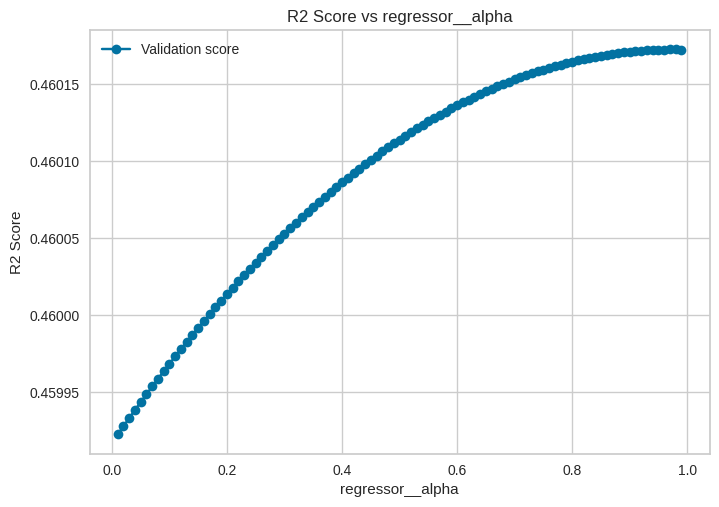

Test R²: 0.493
Train R²:0.470
MSE train: 0.236
MSE test: 0.216
Coefficients du modèle Ridge: 



,Coefs
diagonal,-0.159850
height_left,0.298542
height_right,0.528517
margin_up,0.405857
length,-1.712468


In [77]:
param_grid_ridge = {"regressor__alpha": np.arange(0.01, 1, 0.01)}
ridge_results = optimize_model(Ridge(), X_train, y_train, X_test, y_test, param_grid_ridge)
ridge_best_model = ridge_results['best_model']
ridge_coef = pd.DataFrame(ridge_best_model[-1].coef_, columns=["Coefs"], index=ridge_results['best_model'].feature_names_in_)
print(f"Coefficients du modèle Ridge: \n")
ridge_coef.head()


<font color='green'> **Analyse et commentaires :** </font>

  - Alpha optimisé donne **0.98** (notons que nos données ont subi une normalisation; sans normalisation nous étions aux environ de 9). Cela indique une régularisation relativement forte, ce qui signifie que le modèle a été contraint de réduire l'impact des variables (car plus l'alpha est élevé, plus la régularisation est importante). Cela peut être dû à un compromis entre éviter le sur-apprentissage (overfitting) et avoir un modèle suffisamment souple pour bien s'adapter aux données.
  - Le score R² interne (résultat de la validation croisée sur les données d'entraînement) est de **0.460**. Cela signifie que le modèle peut expliquer environ 46% de la variance des données d'entraînement. Ce n'est pas un score très élevé, mais il n'est pas non plus extrêmement bas. Cela suggère que le modèle Ridge a trouvé une certaine structure dans les données, mais il y a probablement encore des aspects qui ne sont pas bien capturés.
  -Le R² sur le jeu d'entraînement est de **0.47**, légèrement inférieur à celui sur le jeu de test. Cela peut également suggérer que le modèle est légèrement sous-appris ou qu'il est un peu plus difficile de capturer la variance sur les données d'entraînement que sur les données de test. **Cependant, la différence n'est pas très grande, ce qui indique que le modèle ne souffre pas de sur-apprentissage.**
  - L'erreur quadratique moyenne (MSE) sur les données d'entraînement est de **0.236**, et sur les données de test est de **0.216**. Cela signifie que le modèle Ridge a légèrement mieux généralisé sur les données test. Cependant, la différence est faible, ce qui indique que le modèle ne fait pas de prédictions très loin de la réalité. Un MSE plus bas est toujours mieux, et cela montre que l'erreur moyenne sur les prédictions est raisonnable dans les deux cas.

  - **Coefficients du modèle Ridge :**
Les coefficients montrent l'impact de chaque variable sur les prédictions du modèle Ridge. Par exemple, length semble avoir une influence importante (négative) sur la cible, tandis que height_right et height_left ont des effets positifs. Ainsi, augmenter length réduit la prédiction de la cible. Ce coefficient est assez grand en valeur absolue, donc cette variable semble avoir une influence importante, mais dans la direction opposée.


### <font color='darkblue'> **Modèle Lasso**

Best params: {'regressor__alpha': 0.01}
Internal CV score:  0.444


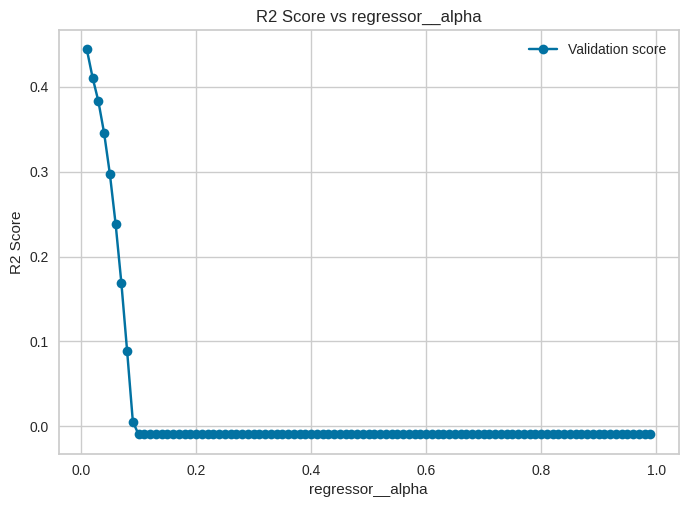

Test R²: 0.477
Train R²:0.454
MSE train: 0.244
MSE test: 0.224
Coefficients du modèle Lasso: 



,Coefs
diagonal,-0.000000
height_left,0.096040
height_right,0.264310
margin_up,0.190986
length,-1.754051


In [78]:
param_grid_lasso = {
    "regressor__alpha": np.arange(0.01,1,0.01)
}
lasso_results = optimize_model(Lasso(), X_train, y_train, X_test, y_test, param_grid_lasso)
lasso_best_model = lasso_results['best_model']
lasso_coef = pd.DataFrame(lasso_best_model[-1].coef_, columns=["Coefs"], index=lasso_best_model.feature_names_in_)
print(f"Coefficients du modèle Lasso: \n")
lasso_coef.head()


<font color='green'> **Analyse et commentaires :**

- Le Lasso fixe le coefficient de diagonal à zéro, indiquant que cette variable est considérée comme non pertinente pour la prédiction de la variable cible. Ceci est une caractéristique clé de Lasso, qui tend à éliminer les variables moins informatives. D'autres variables, comme height_left, height_right, et margin_up, ont des coefficients modérés, tandis que length a une influence plus importante.

- Performances du modèle Lasso : Le modèle Lasso a montré une performance comparable à celle du modèle Ridge avec un R² de 0.477 sur les données de test et un MSE légèrement plus bas (0.224). Le score R² n'est pas très élevé, mais le modèle a été amélioré.

- Régularisation : L'alpha de **0.01** est assez faible, ce qui permet au modèle de conserver une plus grande flexibilité que le Ridge avec un alpha de 0.98. Cela peut être utile si les relations entre les variables sont plus complexes et si l'on souhaite conserver une plus grande influence des variables.

En résumé, le modèle Lasso semble avoir des performances proches de celles du modèle Ridge, mais avec un peu plus de flexibilité grâce à une régularisation plus faible. Il réussit également à éliminer certaines variables inutiles, ce qui peut rendre le modèle plus simple et plus interprétable.








### <font color='darkblue'> **Elastic-Net**

Best params: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.06999999999999999}
Internal CV score:  0.452


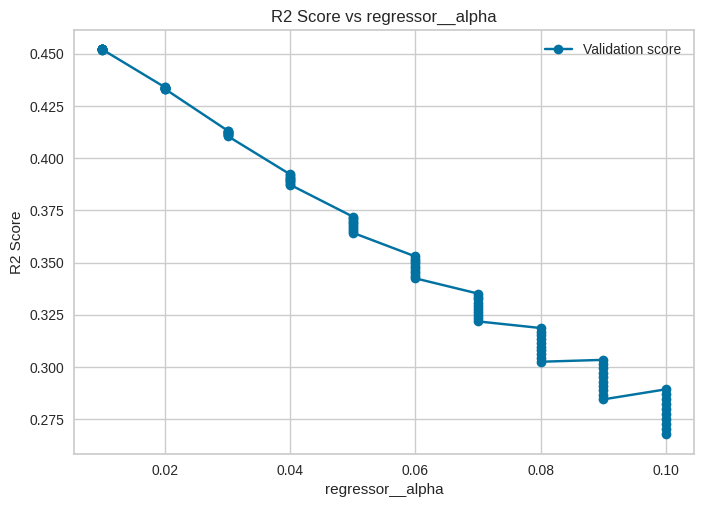

Test R²: 0.479
Train R²:0.459
MSE train: 0.241
MSE test: 0.222
Coefficients du modèle Elastic-Net: 



,Coefs
diagonal,-0.124365
height_left,0.307624
height_right,0.479485
margin_up,0.456544
length,-1.403126


In [79]:
param_grid_en = {
    "regressor__alpha": np.arange(0.01,0.11,0.01),
    "regressor__l1_ratio": np.arange(0.01,0.11,0.01)  # exploration des rapports L1/L2
}
elasticnet_results = optimize_model(ElasticNet(), X_train, y_train, X_test, y_test, param_grid_en)
elasticnet_best_model = elasticnet_results['best_model']
elasticnet_coef = pd.DataFrame(elasticnet_best_model[-1].coef_, columns=["Coefs"], index=elasticnet_best_model.feature_names_in_)
print(f"Coefficients du modèle Elastic-Net: \n")
elasticnet_coef.head()


<font color='green'> **Analyse et commentaires :**

- L’Elastic-Net équilibre les effets de Lasso et Ridge en appliquant une combinaison de pénalités L1 (pour la sélection des variables) et L2 (pour la réduction de la variance). Cela donne des coefficients similaires aux deux autres modèles, mais le modèle conserve les cinq variables.

- Le modèle ElasticNet offre des résultats très compétitifs, avec un R² de 0.479 sur les données de test et un MSE de 0.222, ce qui est un peu mieux que le modèle Lasso, mais moins bon que Ridge.

- Régularisation et paramètres : **L'alpha de 0.01 et le l1_ratio de 0.07** montrent que l'ElasticNet a une régularisation principalement Lasso. Cette combinaison semble bien fonctionner pour ce problème spécifique, en particulier pour la gestion des corrélations entre les variables.

- Coefficients et sélection de variables : Comme pour Lasso, diagonal a un coefficient relativement faible, ce qui peut suggérer qu'elle est moins importante pour la prédiction. D'autres variables comme height_left, height_right, et margin_up ont des coefficients plus élevés, indiquant qu'elles jouent un rôle plus important dans la prédiction. La variable length reste très influente avec un coefficient relativement élevé et négatif, ce qui la rend cruciale pour la compréhension du modèle.

# <font color='darkblue'>**Conclusion**

En se basant sur les scores R² test et les MSE test, le modèle Ridge semble être légèrement meilleur que Lasso et ElasticNet sur cet ensemble de données, avec un R² test de 0.493 et un MSE test de 0.216. Ridge fournit une bonne généralisation sans réduire à zéro certains coefficients, ce qui signifie qu'il prend en compte l'influence de chaque variable.

Cela peut être dû au fait que d'entrée de jeu, les variables n'étaient pas très fortement correlées.